In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import copy
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/content/drive/MyDrive/induction_motor')
import modules,scaler


In [2]:
normal_data = pd.read_csv('/content/drive/MyDrive/induction_motor/combined_data.csv')


In [3]:
anomalous_data = pd.read_csv('/content/drive/MyDrive/induction_motor/combined_anomalous.csv')

In [4]:
normal_data.shape, anomalous_data.shape

((3170000, 3), (3170000, 3))

In [5]:


train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(normal_data)
train_scaled = train_scaler.transform(normal_data)
anomalous_scaled = train_scaler.transform(anomalous_data)

using MinMaxScaler()


In [6]:
normal_data.shape, anomalous_data.shape

((3170000, 3), (3170000, 3))

In [22]:
train = train_scaled[:2530000]
test = train_scaled[2530000:]

In [7]:

# model subclassing
class AutoEncoder(Model):
  def __init__(self,activation='relu'):
# In this code, AutoEncoder is a subclass of the Model class from the TensorFlow Keras API. When defining a subclass of a Python class, it is necessary to call the constructor of the parent class in order to initialize any inherited attributes or methods.
# The super() function is used to call the constructor of the parent class. In this case, it calls the constructor of the Model class to initialize the AutoEncoder object as a Keras model.
# Even though Model is not explicitly defined in the code, it is inherited by the AutoEncoder class, as it is defined in the TensorFlow Keras API. By calling super(AutoEncoder, self).__init__(), the constructor of the parent class (Model) is called, which initializes the necessary attributes for AutoEncoder to function as a Keras model.
    super(AutoEncoder, self).__init__()  #not required but ensures that the AutoEncoder class is properly initialized as a Keras model, and it is compatible with other Keras models and tools.   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation=activation),
      tf.keras.layers.Dense(32, activation=activation),
      tf.keras.layers.Dense(16, activation=activation),
      tf.keras.layers.Dense(8, activation=activation)])
    
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation=activation),
      tf.keras.layers.Dense(32, activation=activation),
      tf.keras.layers.Dense(64, activation=activation),
      tf.keras.layers.Dense(3)]) #just a linear function
    
  def call(self, x):
    encoded = self.encoder(x)  #compresses the data
    decoded = self.decoder(encoded) #reconstructs the original data 
    return decoded
  



In [23]:
model= AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',     #stop if val_loss does not improve for more than 2 epochs
                                                    patience=4,
                                                    mode='min')  #check for min of val_loss, if accuracy then it should be max, 'auto' does it automatically

model.compile(optimizer='adam', loss='mae')  



In [24]:
file = 0
for i in tqdm(range(0, len(train), 10000)):
    train_batch = train[i:i+10000]
    test_batch = test[(i % len(test)): (i % len(test)) + 10000]

    history = model.fit(train_batch, train_batch,
                        epochs=100,
                        batch_size=128,
                        validation_data=(test_batch, test_batch),
                        shuffle=False,
                        callbacks=[early_stopping],
                        verbose=0)

100%|██████████| 253/253 [19:02<00:00,  4.52s/it]


In [ ]:
from tensorflow.keras.utils import model_to_dot
import graphviz

# Get the dot representation of the model
dot = model_to_dot(model).to_string()

# Use graphviz to render the model and get its size
graph = graphviz.Source(dot)
print("Model size (in bytes):", graph.pipe(format='pdf').__sizeof__())

Model size (in bytes): 6613


In [ ]:
model.save('ffn_autoencoder')

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('ffn_autoencoder')

testing on self

In [25]:
encoder_out = model.encoder(train_scaled).numpy()
decoder_out = model.decoder(encoder_out).numpy()

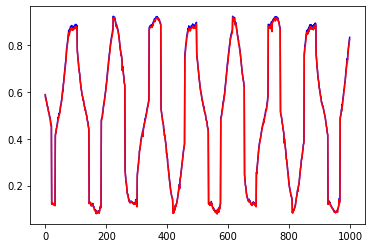

In [26]:
plt.plot(train_scaled[0:1000,0:1],'b')
plt.plot(decoder_out[0:1000,0:1],'r')

In [27]:
np.mean(tf.keras.losses.mae(decoder_out, train_scaled))

0.0044737625499636285

Testing on anomalous ( less anomalous )

In [28]:
encoder_out_a = model.encoder(anomalous_scaled).numpy()
decoder_out_a = model.decoder(encoder_out_a).numpy()

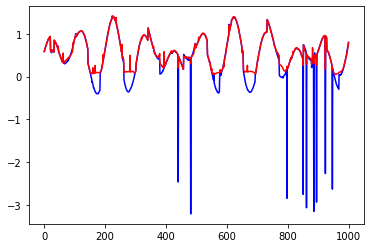

In [29]:
plt.plot(anomalous_scaled[0:1000,0:1],'b')
plt.plot(decoder_out_a[0:1000,0:1],'r')

In [30]:
np.mean(tf.keras.losses.mae(decoder_out_a, anomalous_scaled))

0.10901623453997616

Testing on noisy

In [ ]:
noisy = pd.read_csv('/content/drive/MyDrive/induction_motor/noisy_data.csv')
noisy_scaled = train_scaler.transform(noisy)


<AxesSubplot:>

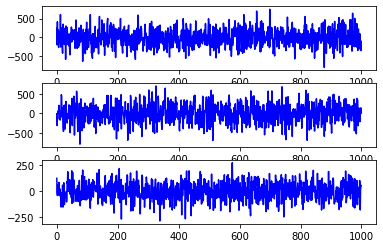

In [ ]:
plt.subplot(3, 1, 1)
plt.plot(noisy['current_1'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 2)
plt.plot(noisy['current_2'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 3)
plt.plot(noisy['current_3'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 1)

In [ ]:
encoder_out_n = model.encoder(noisy_scaled).numpy()
decoder_out_n = model.decoder(encoder_out_a).numpy()

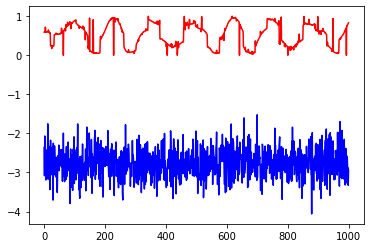

In [ ]:
plt.plot(noisy_scaled[0:1000,0:1],'b')
plt.plot(decoder_out_n[0:1000,0:1],'r')

In [ ]:
decoder_out_n.shape, noisy_scaled.shape

((10000, 3), (1000, 3))

In [ ]:
np.mean(tf.keras.losses.mae(decoder_out_n[0:1000], noisy_scaled))


2.391773482258329

more anomalous data

In [ ]:
df_a = modules.AnomalyGenerator.add_anomalies(normal_data[0:10000], spike_magnitude=50,spike_probability=0.02, dropout_probability=0.01, drift_amplitude=300, drift_frequency=0.01,transient_magnitude=1000, transient_duration=1000)

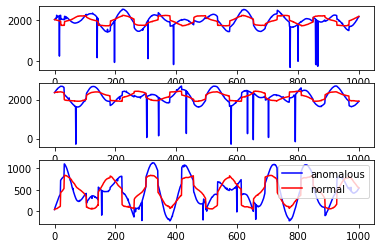

In [ ]:
plt.subplot(3, 1, 1)
plt.plot(df_a['current_1'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 2)
plt.plot(df_a['current_2'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 3)
plt.plot(df_a['current_3'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 1)
plt.plot(normal_data['current_1'].loc[0:1000],'r',label='normal')
plt.subplot(3, 1, 2)
plt.plot(normal_data['current_2'].loc[0:1000],'r',label='normal')
plt.subplot(3, 1, 3)
plt.plot(normal_data['current_3'].loc[0:1000],'r',label='normal')
plt.legend()

In [ ]:
df_a_scaled = train_scaler.transform(df_a)

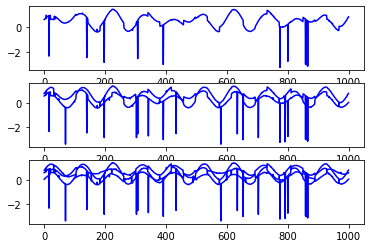

In [ ]:
plt.subplot(3, 1, 1)
plt.plot(df_a_scaled[0:1000,0:1],'b',label='anomalous')
plt.subplot(3, 1, 2)
plt.plot(df_a_scaled[0:1000,0:2],'b',label='anomalous')
plt.subplot(3, 1, 3)
plt.plot(df_a_scaled[0:1000,0:3],'b',label='anomalous')

In [ ]:
encoder_out_df_a = model.encoder(df_a_scaled).numpy()
decoder_out_df_a = model.decoder(encoder_out_df_a).numpy()

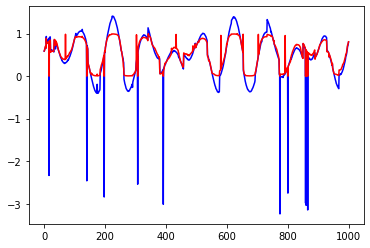

In [ ]:
plt.plot(df_a_scaled[0:1000,0:1],'b')
plt.plot(decoder_out_df_a[0:1000,0:1],'r')

In [ ]:
np.mean(tf.keras.losses.mae(decoder_out_df_a, df_a_scaled))

0.22390506598712154

visualizing losses on train data and calculating a threshold for anomalies

In [31]:
reconstructions = model.predict(train_scaled)
train_loss = tf.keras.losses.mae(reconstructions, train_scaled)

99063/99063 [==============================] - 177s 2ms/step


<Axes: ylabel='Density'>

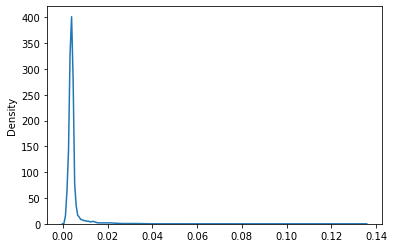

In [32]:
import seaborn as sns
sns.kdeplot(train_loss, bw_adjust= 0.5)

In [33]:
threshold = np.mean(train_loss) + 4*np.std(train_loss)

In [34]:
threshold

0.017724851901951284

In [35]:
np.sum(train_loss > threshold)

53795

find indices and files of anomalies

In [36]:
indices = np.where(tf.math.less(train_loss, threshold) == False)[0]

In [37]:

file_size = 10000
num_files = len(train_scaled) // file_size
ano_dict = {}
# Create histogram of indices based on file number
hist, bin_edges = np.histogram(indices, bins=num_files, range=(0, len(train_scaled)))
file_indices = np.digitize(indices, bin_edges[:-1])

# Count number of anomalies per file
file_counts = {}
for i in range(1, num_files+1):
    file_counts[i] = np.count_nonzero(file_indices == i)

# Sort files by number of anomalies (in descending order)
sorted_files = sorted(file_counts.items(), key=lambda x: x[1], reverse=True)

# Print results
for file_num, count in sorted_files:
  ano_dict[file_num] = count

In [38]:
def fil(pair):
  key,value = pair
  if value >= 150:
    return True
  else:
    return False

In [39]:
dict(filter(fil,ano_dict.items()))

{215: 2347,
 221: 2336,
 216: 2327,
 220: 2314,
 219: 2305,
 217: 2299,
 218: 2298,
 214: 2285,
 199: 2273,
 212: 2255,
 224: 2233,
 207: 2232,
 213: 2229,
 210: 2222,
 225: 2222,
 208: 2206,
 201: 2197,
 209: 2192,
 206: 2168,
 204: 2157,
 205: 2116,
 203: 2105,
 202: 2056,
 198: 2024}

For real Real time : generator function that reads and yields batches of data from the files as they come

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, file_paths, batch_size):
    self.file_paths = file_paths
    self.batch_size = batch_size

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    file_path = self.file_paths[idx]
    data = load_data(file_path) # implement this function to load data from file
    batch_idx = 0
    while (batch_idx + 1) * self.batch_size <= len(data):
      batch = data[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
      batch_idx += 1
      yield batch, batch # return the batch as both x and y, since this is an unsupervised learning task

# Define the file paths
file_paths = [...] # list of file paths

# Initialize the data generator
batch_size = 128
data_generator = DataGenerator(file_paths, batch_size)

# Initialize the model
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
model.compile(optimizer='adam', loss='mae')

# Train the model
for epoch in range(50):
  print(f'Epoch {epoch+1}/{50}')
  for i, (x, y) in enumerate(data_generator):
    loss = model.train_on_batch(x, y)
    print(f'Batch {i+1}/{len(data_generator)} - Loss: {loss:.4f}')


`DataGenerator` class inherits from `tf.keras.utils.Sequence` and implements the `__len__` and `__getitem__` methods. The `__len__` method returns the number of files in the `file_paths list`, and the `__getitem__` method reads and yields batches of data from each file. The `train_on_batch` method is used to train the model on each batch of data, and the progress is printed to the console. The outer loop iterates over epochs, and the inner loop iterates over files using the `DataGenerator`.